# Analyzer

In  our  context,  we  define  evolvability  as  the  ease  with  which  a  software  system  or  a 
component  can  evolve  while  preserving  its  design  as  much  as  possible.  In  the  case  of  OO  
class  libraries,  we  restrict  the  preservation  of  the  design  to  the  preserv
ation  of  the  library  
interface.  This  is  important  when  we  consider  that  the  evolution  of  a  system  that  uses  a  
library  is  directly  influenced  by  the  evolvability  of  the  library.  For  instance,  a  system  that  
uses  version  i  of  a  library  can  easily  be  upgraded  
with  version  i+1  of  the  same  library  if  
the new version preserves the interface of the older one.

Analyzer is a python program that tries to gauge the maintainability of java software. To achieve this, it tries to measure the complxity of the software under evalutation. As the Wikipedia article (https://en.wikipedia.org/wiki/Programming_complexity) on programming complexity states : 

As the number of entities increases, the number of interactions between them would increase exponentially, and it would get to a point where it would be impossible to know and understand all of them. Similarly, higher levels of complexity in software increase the risk of unintentionally interfering with interactions and so increases the chance of introducing defects when making changes. In more extreme cases, it can make modifying the software virtually impossible.

Analyzer tries to measure that complexity by taking several factors into account :
1. Commit frequency. This can find the 'hotspots' in code where many changes were performed and which can be problem zones. This idea was proposed by Adam Tornhill in 'Your Code as a Crime Scene'.
2. Distinct number of committers. This metric will tell us how many people worked on the code, thereby increading complexity.
3. Class reference count. This metric measures the degree of coupling betweem classes by counting the references to them.
4. Inheritance count. This is a measure of the coupling that exists because of inheritance.
5. Lines of code. A rather crude metric that tries to measure the length of our software system.
6. Number of methods. This is a measure of the complexity of the system.
7. Halstead complexity measures : https://en.wikipedia.org/wiki/Halstead_complexity_measures
8. Cyclomatic Complexity : https://en.wikipedia.org/wiki/Cyclomatic_complexity

To add to these metrics, we propose to use the metrics as proposed by Sanjay Misra en Ferid Cafer in their paper 'ESTIMATING COMPLEXITY OF PROGRAMS IN PYTHON LANGUAGE'.
To quote from this paper :

Complexity of a system depends on the following factors  :
1. Complexity due to classes. Class is a basic unit of object oriented software development. All the functions are distributed in different classes. Further classes in the object-oriented code either are in inheritance hierarchy or distinctly distributed. Accordingly, the complexity of all the classes is due to classes in inheritance hierarchy and the complexity of distinct classes.
2. Complexity due to global factors: The second important factor, which is normally neglected in calculating complexity of object-oriented codes, is the complexity of global factors in main program.
3. Complexity due to coupling: Coupling is one of the important factors for increasing complexity of object- oriented code.

The aim of this chapter is to discover trends in news articles by clustering, or grouping, them together. To do that, we will use the k-means algorithm, a classic machine-learning algorithm originally developed in 1957.
Clustering is an unsupervised learning technique and we use clustering algorithms for exploring data. Our dataset contains approximately 500 stories, and it would
be quite arduous to examine each of those stories individually. Even if we
used summary statistics, that is still a lot of data. Using clustering allows us to group similar stories together, and we can explore the themes in each cluster independently.

We use clustering techniques when we don't have a clear set of target classes for our data. In that sense, clustering algorithms have little direction in their learning. They learn according to some function, regardless of the underlying meaning of the data. For this reason, it is critical to choose good features. In supervised learning,
if you choose poor features, the learning algorithm can choose to not use those features. For instance, support vector machines will give little weight to features that aren't useful in classi cation. However, with clustering, all features are used in the  nal result—even if those features don't provide us with the answer we were looking for.
When performing cluster analysis on real-world data, it is always a good idea to
have a sense of what sorts of features will work for your scenario. In this chapter, we will use the bag-of-words model. We are looking for topic-based groups, so we will use topic-based features to model the documents. We know those features work because
of the work others have done in supervised versions of our problem. In contrast, if we were to perform an authorship-based clustering, we would use features such as those found in the Chapter 9, Authorship Attribution experiment.


In [2]:
# Imports and directives

%matplotlib inline
import numpy as np
from math import log
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA as mlabPCA
import javalang
import os, re, requests, zipfile, json, operator
from collections import Counter
import colorsys
import random
from StringIO import StringIO
from subprocess import Popen, PIPE
from sklearn.cluster import KMeans
from tabulate import tabulate
from sklearn import svm

In [3]:
# Variables

USER = 'apache' # github user of the repo that is analysed
REPO = 'tomcat' # repository to investigate
BASE_PATH = '/Users/philippepossemiers/Documents/Dev/Spark/data/analyzer/' # local expansion path
COMMENT_LINES = ['/*', '//', '*/', '* '] # remove comments from code
KEY_WORDS = ['abstract','continue','for','new','switch','assert','default','goto','synchronized',
            'boolean','do','if','private','this','break','double','implements','protected','throw',
            'byte','else','public','throws','case','enum','instanceof','return','transient',
            'catch','extends','int','short','try','char','final','interface','static','void',
            'class','finally','long','strictfp','volatile','const','float','native','super','while'
            'true','false','null']
TOP = 25 # number of items to show in graphs
# list of operators to find in source code
OPERATORS = ['\+\+','\-\-','\+=','\-=','\*\*','==','!=','>=','<=','\+','=','\-','\*','/','%','!','&&', \
             '\|\|','\?','instanceof','~','<<','>>','>>>','&','\^','<','>']
# list of variable types to find in source code
OPERANDS = ['boolean','byte','char','short','int','long','float','double','String']
GIT_COMMIT_FIELDS = ['author_name', 'committer name', 'date', 'message', 'name']
GIT_LOG_FORMAT = ['%an', '%cn', '%ad', '%s']
GIT_LOG_FORMAT = '%x1f'.join(GIT_LOG_FORMAT) + '%x1e'

In [4]:
# List of Apache Java projects on github

APACHE_PROJECTS = ['abdera', 'accumulo', 'ace', 'activemq', 'airavata', 'ambari', 'ant', 'ant-antlibs-antunit', \
                   'any23', 'archiva', 'aries', 'webservices-axiom', 'axis2-java', \
                   'bigtop', 'bookkeeper', 'bval', 'calcite', 'camel', 'cassandra', 'cayenne', \
                   'chainsaw', 'chukwa', 'clerezza', 'commons-bcel', \
                   'commons-beanutils', 'commons-bsf', 'commons-chain', 'commons-cli', 'commons-codec', \
                   'commons-collections', 'commons-compress', 'commons-configuration', 'commons-daemon', \
                   'commons-dbcp', 'commons-dbutils', 'commons-digester', 'commons-discovery', \
                   'commons-email', 'commons-exec', 'commons-fileupload', 'commons-functor', 'httpcomponents-client', \
                   'commons-io', 'commons-jci', 'commons-jcs', 'commons-jelly', 'commons-jexl', 'commons-jxpath', \
                   'commons-lang', 'commons-launcher', 'commons-logging', 'commons-math', \
                   'commons-net', 'commons-ognl', 'commons-pool', 'commons-proxy', 'commons-rng', 'commons-scxml', \
                   'commons-validator', 'commons-vfs', 'commons-weaver', 'continuum', 'crunch', \
                   'ctakes', 'curator', 'cxf', 'derby', 'directmemory', \
                   'directory-server', 'directory-studio', 'drill', 'empire-db', 'falcon', 'felix', 'flink', \
                   'flume', 'fop', 'directory-fortress-core', 'ftpserver', 'geronimo', 'giraph', 'gora', \
                   'groovy', 'hadoop', 'hama', 'harmony', 'hbase', 'helix', 'hive', 'httpcomponents-client', \
                   'httpcomponents-core', 'jackrabbit', 'jena', 'jmeter', 'lens', 'log4j', \
                   'lucene-solr', 'maven', 'maven-doxia', 'metamodel', 'mina', 'mrunit', 'myfaces', 'nutch', 'oozie', \
                   'openjpa', 'openmeetings', 'openwebbeans', 'orc', 'phoenix', 'pig', 'poi','rat', 'river', \
                   'shindig', 'sling', \
                   'sqoop', 'struts', 'synapse', 'syncope', 'tajo', 'tika', 'tiles', 'tomcat', 'tomee', \
                   'vxquery', 'vysper', 'whirr', 'wicket', 'wink', 'wookie', 'xmlbeans', 'zeppelin', 'zookeeper']

print len(APACHE_PROJECTS)

134


In [5]:
# Global dictionaries

joined = [] # list with all source files
commit_dict = {} # commits per class
reference_dict = {} # number of times a class is referenced
lines_dict = {} # number of lines per class
methods_dict = {} # number of functions per class
operators_dict = {} # number of operators per class
operands_dict = {} # number of operands per class
halstead_dict = {} # Halstead complexity measures
cyclomatic_dict = {} # cyclomatic complexity

In [6]:
# Utility functions

# TODO : check if we can use this
def sanitize(contents):
    lines = contents.split('\n')

    # remove stop lines
    for stop_line in COMMENT_LINES:
        lines = [line.lower().lstrip().replace(';', '') for line in lines if stop_line not in line and line <> '']
    
    return '\n'.join(lines)

def find_whole_word(word):
    return re.compile(r'\b({0})\b'.format(word), flags=re.IGNORECASE).search

def all_files(directory):
    for path, dirs, files in os.walk(directory):
        for f in files:
            yield os.path.join(path, f)

def build_joined(repo):
    src_list = []
    repo_url = 'https://github.com/' + repo[0] + '/' + repo[1]
    os.chdir(BASE_PATH)
    os.system('git clone {}'.format(repo_url))
    
    # get all java source files
    src_files = [f for f in all_files(BASE_PATH + repo[1]) if f.endswith('.java')]

    for f in src_files:
        try:
            # read contents
            code = open(f, 'r').read()
            # https://github.com/c2nes/javalang
            tree = javalang.parse.parse(code)
            # create tuple with package + class name and code + tree + file path
            src_list.append((tree.package.name + '.' + tree.types[0].name, (code, tree, f)))
        except:
            pass

    return src_list

def parse_git_log(repo_dir, src):
    # first the dictionary with all classes 
    # and their commit count
    total = 0
    p = Popen('git log --name-only --pretty=format:', shell=True, stdout=PIPE, cwd=repo_dir)
    (log, _) = p.communicate()
    log = log.strip('\n\x1e').split('\x1e')
    log = [r.strip().split('\n') for r in log]
    log = [r for r in log[0] if '.java' in r]
    log2 = []
    for f1 in log:
        for f2 in src:
            if f2[1][2].find(f1) > -1:
                log2.append(f2[0])
    cnt_dict = Counter(log2)
    
    for key, value in cnt_dict.items():
        total += value
        
    cnt_dict['total'] = total

    # and then the list of commits as dictionaries
    p = Popen('git log --format="%s"' % GIT_LOG_FORMAT, shell=True, stdout=PIPE, cwd=repo_dir)
    (log, _) = p.communicate()
    log = log.strip('\n\x1e').split("\x1e")
    log = [row.strip().split("\x1f") for row in log]
    log = [dict(zip(GIT_COMMIT_FIELDS, row)) for row in log]
    # now get list of distinct committers
    committers = len(set([x['committer name'] for x in log]))
    cnt_dict['committers'] = committers
    
    return cnt_dict
    
def count_inheritance(src):
    count = 0
    for name, tup in src:
        if find_whole_word('extends')(tup[0]):
            count += 1
        
    return count
    
def count_references(src):
    names, tups = zip(*src)
    dict = {e : 0 for i, e in enumerate(names)}
    total = 0
    
    for name in names:
        c_name = name[name.rfind('.'):]
        for tup in tups:
            if find_whole_word(c_name)(tup[0]):
                dict[name] += 1
                total += 1
                
    dict['total'] = total
    
    # sort by amount of references
    return {k: v for k, v in dict.iteritems() if v > 1}

def count_lines(src):
    dict = {e : 0 for i, e in enumerate(src)}
    total = 0
    
    for name, tup in src:
        dict[name] = 0
        lines = tup[0].split('\n')
        for line in lines:
            if line != '\n':
                dict[name] += 1
                total += 1
    
    dict['total'] = total
    
    # sort by amount of lines
    return {k: v for k, v in dict.iteritems()}

# constructors not counted
def count_methods(src):
    dict = {e : 0 for i, e in enumerate(src)}
    total = 0
    
    for name, tup in src:
        dict[name] = len(tup[1].types[0].methods)
        total += dict[name]
        
    dict['total'] = total
        
    # sort by amount of functions
    return {k: v for k, v in dict.iteritems()}

def count_operators(src):
    dict = {key: 0 for key in OPERATORS}
    
    for name, tup in src:
        for op in OPERATORS:
            # if operator is in list, match it without anything preceding or following it
            # eg +, but not ++ or +=
            if op in ['\+','\-','!','=']:
                # regex excludes followed_by (?!) and preceded_by (?<!)
                dict[op] += len(re.findall('(?!\-|\*|&|>|<|>>)(?<!\-|\+|=|\*|&|>|<)' + op, tup[0])) 
            else:
                dict[op] += len(re.findall(op, tup[0]))
    
    # TODO : correct bug with regex for the '++'
    dict['\+'] -= dict['\+\+']
    
    total = 0
    distinct = 0
    for key in dict:
        if dict[key] > 0:
            total += dict[key]
            distinct += 1
    dict['total'] = total
    dict['distinct'] = distinct
    
    return dict

def count_operands(src):
    dict = {key: 0 for key in OPERANDS}
    
    for name, tup in src:
        lines = tup[0].split('\n')
        for line in lines:
            for op in OPERANDS:
                if op in line:
                    dict[op] += 1 + line.count(',')

    total = 0
    distinct = 0
    for key in dict:
        if dict[key] > 0:
            total += dict[key]
            distinct += 1
    dict['total'] = total
    dict['distinct'] = distinct

    return dict

def calc_cyclomatic_complexity(src):
    dict = {}
    total = 0
    
    for name, tup in src:
        dict[name] = 1
        dict[name] += len(re.findall('if|else|for|switch|while', tup[0]))
        total += dict[name]
        
    dict['total'] = total
        
    # sort by amount of complexity
    return {k: v for k, v in dict.iteritems()}

def make_hbar_plot(dictionary, title, x_label, top=TOP):
    # show top classes
    vals = sorted(dictionary.values(), reverse=True)[:top]
    lbls = sorted(dictionary, key=dictionary.get, reverse=True)[:top]

    # make plot
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(title, fontsize=15)
    ax = fig.add_subplot(111)

    # set ticks
    y_pos = np.arange(len(lbls)) + 0.5
    ax.barh(y_pos, vals, align='center', alpha=0.4, color='lightblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(lbls)
    ax.set_xlabel(x_label)

    plt.show()
    pass

# Clustering
def random_centroid_selector(total_clusters , clusters_plotted):
    random_list = []
    for i in range(0, clusters_plotted):
        random_list.append(random.randint(0, total_clusters - 1))
        
    return random_list

def plot_cluster(kmeansdata, centroid_list, names, num_cluster, title):
    mlab_pca = mlabPCA(kmeansdata)
    cutoff = mlab_pca.fracs[1]
    users_2d = mlab_pca.project(kmeansdata, minfrac=cutoff)
    centroids_2d = mlab_pca.project(centroid_list, minfrac=cutoff)

    # make plot
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(title, fontsize=15)
    ax = fig.add_subplot(111)
    
    plt.xlim([users_2d[:, 0].min() - 3, users_2d[:, 0].max() + 3])
    plt.ylim([users_2d[:, 1].min() - 3, users_2d[:, 1].max() + 3])

    random_list = random_centroid_selector(num_cluster, 50)

    for i, position in enumerate(centroids_2d):
        if i in random_list:
            plt.scatter(centroids_2d[i, 0], centroids_2d[i, 1], marker='o', c='red', s=100)

    for i, position in enumerate(users_2d):
        plt.scatter(users_2d[i, 0], users_2d[i, 1], marker='o', c='lightgreen')

    for label, x, y in zip(names, users_2d[:, 0], users_2d[:, 1]):
        ax.annotate(
            label,
            xy = (x, y), xytext=(-15, 15),
            textcoords = 'offset points', ha='right', va='bottom',
            bbox = dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    pass

In [6]:
# first build list of source files
joined = build_joined((USER, REPO))

## Commit frequency

Distinct committers : 35


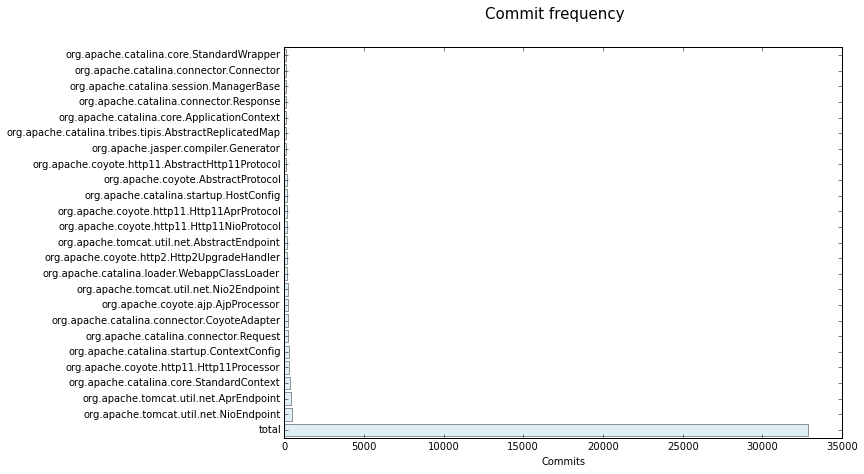

In [16]:
commit_dict = parse_git_log(BASE_PATH + REPO, joined)
print 'Distinct committers : ' + str(commit_dict['committers'])
make_hbar_plot(commit_dict, 'Commit frequency', 'Commits', TOP)

## Class reference count

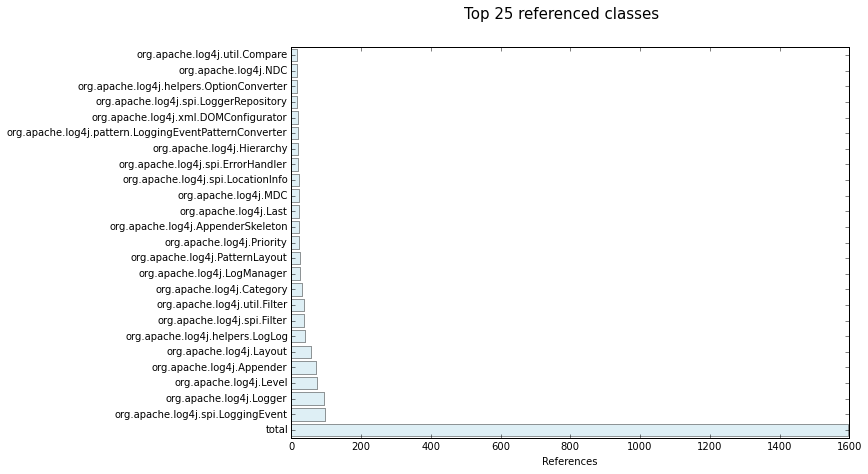

In [20]:
reference_dict = count_references(joined)
make_hbar_plot(reference_dict, 'Top 25 referenced classes', 'References', TOP)

## Inheritance count

In [21]:
inheritance_count = count_inheritance(joined)
print 'Inheritance count : ' + inheritance_count

155


## Lines of code

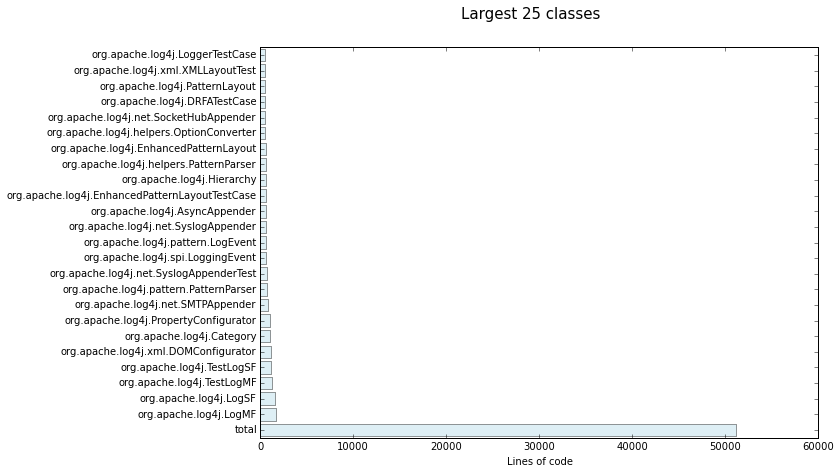

In [22]:
lines_dict = count_lines(joined)
make_hbar_plot(lines_dict, 'Largest 25 classes', 'Lines of code', TOP)

## Number of methods

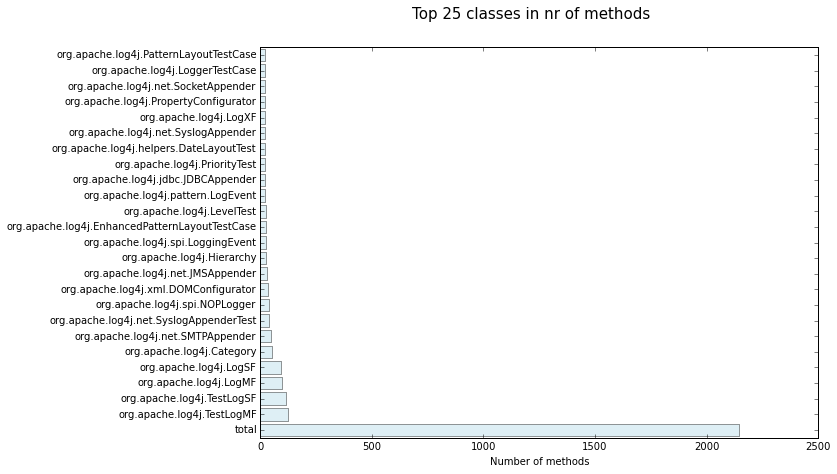

In [23]:
methods_dict = count_methods(joined)
make_hbar_plot(methods_dict, 'Top 25 classes in nr of methods', 'Number of methods', TOP)

## Halstead complexity measures

To measure the Halstead complexity, following metrics are taken into account :
* the number of distinct operators (https://docs.oracle.com/javase/tutorial/java/nutsandbolts/opsummary.html)
* the number of distinct operands
* the total number of operators
* the total number of operands

### Number of operators

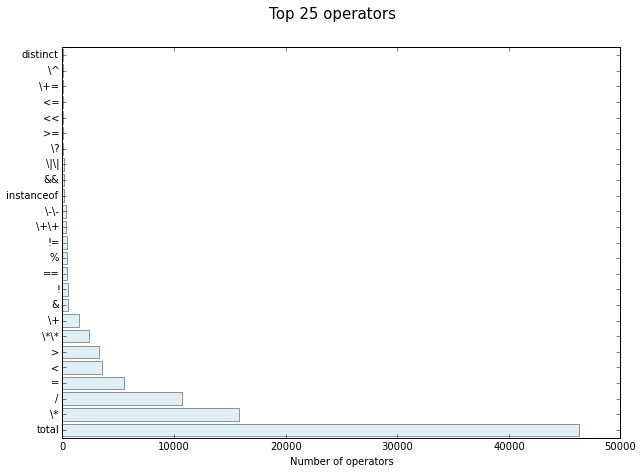

In [24]:
operators_dict = count_operators(joined)
make_hbar_plot(operators_dict, 'Top 25 operators', 'Number of operators', TOP)

### Number of operands

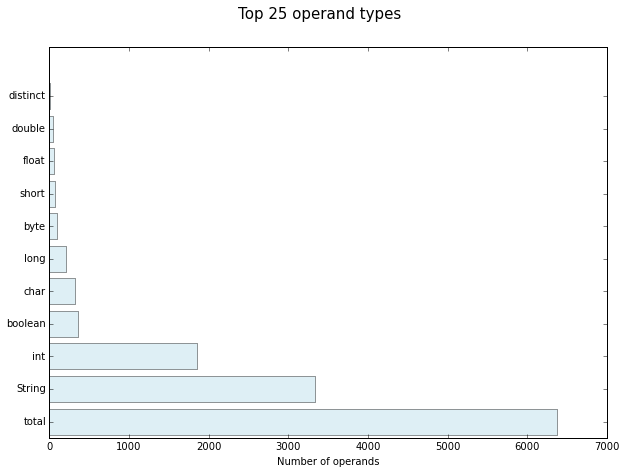

In [25]:
operands_dict = count_operands(joined)
make_hbar_plot(operands_dict, 'Top 25 operand types', 'Number of operands', TOP)

### Complexity measures

In [27]:
halstead_dict['PROGRAM_VOCABULARY'] = operators_dict['distinct'] + operands_dict['distinct']
halstead_dict['PROGRAM_LENGTH'] = round(operators_dict['total'] + operands_dict['total'], 0)
halstead_dict['VOLUME'] = round(halstead_dict['PROGRAM_LENGTH'] * log(halstead_dict['PROGRAM_VOCABULARY'], 2), 0)
halstead_dict['DIFFICULTY'] = (operators_dict['distinct'] / 2) * (operands_dict['total'] / operands_dict['distinct'])
halstead_dict['EFFORT'] = round(halstead_dict['VOLUME'] * halstead_dict['DIFFICULTY'], 0)
halstead_dict['TIME'] = round(halstead_dict['EFFORT'] / 18, 0)
halstead_dict['BUGS'] = round(halstead_dict['VOLUME'] / 3000, 0)

print halstead_dict

{'PROGRAM_VOCABULARY': 34, 'BUGS': 89.0, 'VOLUME': 267977.0, 'DIFFICULTY': 8484, 'PROGRAM_LENGTH': 52674.0, 'TIME': 126306493.0, 'EFFORT': 2273516868.0}


## Cyclomatic complexity

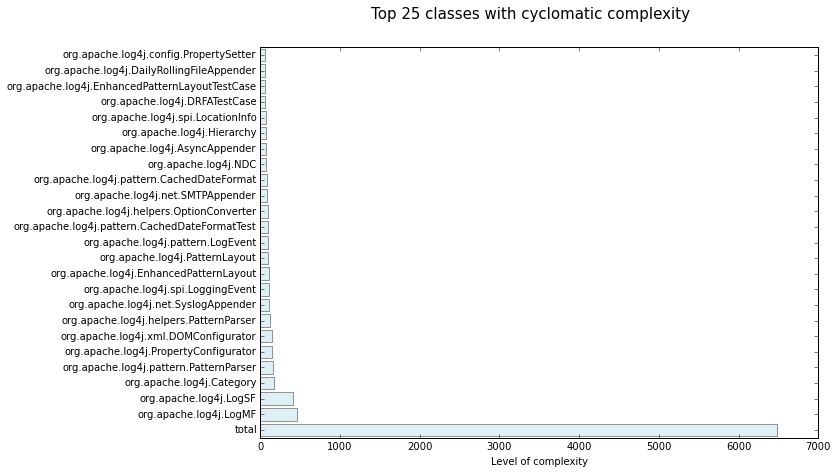

In [28]:
cyclomatic_dict = calc_cyclomatic_complexity(joined)
make_hbar_plot(cyclomatic_dict, 'Top 25 classes with cyclomatic complexity', 'Level of complexity', TOP)

## Clustering several projects

In [7]:
# featurize all metrics
def make_features(repo, dict):
    features = []
    
    for key, value in dict.items():
        features.append(int(value))
    
    return features

# iterate all repos 
def make_rows(repos):
    rows = []
    
    try:
        for repo in repos:
            dict = {}
            joined = build_joined(repo)

            dict['commits'] = parse_git_log(BASE_PATH + repo[1], joined)['total']
            dict['references'] = count_references(joined)['total']
            dict['inheritance'] = count_inheritance(joined)
            dict['lines'] = count_lines(joined)['total']
            dict['methods'] = count_methods(joined)['total']
            operators_dict = count_operators(joined)
            operands_dict = count_operands(joined)
            dict['program_vocabulary'] = operators_dict['distinct'] + operands_dict['distinct']
            dict['program_length'] = round(operators_dict['total'] + operands_dict['total'], 0)
            dict['volume'] = round(dict['program_length'] * log(dict['program_vocabulary'], 2), 0)
            dict['difficulty'] = (operators_dict['distinct'] / 2) * (operands_dict['total'] / operands_dict['distinct'])
            dict['effort'] = round(dict['volume'] * dict['difficulty'], 0)
            dict['time'] = round(dict['effort'] / 18, 0)
            dict['bugs'] = round(dict['volume'] / 3000, 0)
            dict['cyclomatic'] = calc_cyclomatic_complexity(joined)['total']

            rows.append(make_features(repo, dict))
    except:
        pass
    
    return rows

def cluster_repos(arr, nr_clusters):
    kmeans = KMeans(n_clusters=nr_clusters)
    kmeans.fit(arr)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    return (centroids, labels)

### Construct model with Apache projects

In [8]:
repositories = [('apache', x) for x in APACHE_PROJECTS]

In [12]:
rows = make_rows(repositories[:5])
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111]]


In [15]:
rows.append(make_rows(repositories[5:10]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]]]


In [16]:
rows.append(make_rows(repositories[10:15]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]], [[13050, 889, 35194, 755

In [17]:
rows.append(make_rows(repositories[15:20]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]], [[13050, 889, 35194, 755

In [18]:
rows.append(make_rows(repositories[20:25]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]], [[13050, 889, 35194, 755

In [20]:
rows.append(make_rows(repositories[25:30]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]], [[13050, 889, 35194, 755

In [21]:
rows.append(make_rows(repositories[25:30]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]], [[13050, 889, 35194, 755

In [22]:
rows.append(make_rows(repositories[30:35]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]], [[13050, 889, 35194, 755

In [23]:
rows.append(make_rows(repositories[35:40]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [[29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670]], [[13050, 889, 35194, 755

In [33]:
# Because of using append (and not extend), the array has the wrong dimensions
# This is corrected here
rows2 = rows[:5]

for row_coll in rows[5:]:
    rows2.extend(row_coll)
        
rows = rows2
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670], [13050, 889, 35194, 7558, 

In [34]:
rows.extend(make_rows(repositories[40:45]))
print rows

[[6566, 384, 9416, 3906, 95025, 36, 146, 437707, 22906, 11298, 84664, 557006475, 10026116542], [15406, 1060, 144673, 18102, 630470, 36, 853, 2558906, 155298, 30203, 494960, 22077387999, 397392983988], [3852, 228, 14917, 2412, 93126, 36, 158, 474703, 20696, 6844, 91820, 545802960, 9824453288], [35114, 3049, 69789, 12527, 649765, 36, 1014, 3042609, 159666, 89509, 588521, 26988956033, 485801208594], [18704, 589, 224437, 17342, 923130, 36, 1160, 3480187, 185653, 21991, 673160, 35894842062, 646107157111], [29794, 1798, 74265, 30112, 760915, 36, 1237, 3711758, 169039, 72690, 717952, 34857325587, 627431860562], [10953, 663, 33461, 21462, 257534, 36, 515, 1544562, 43719, 27217, 298759, 3751483671, 67526706078], [296, 29, 568, 195, 5417, 27, 8, 25429, 890, 129, 5348, 1257323, 22631810], [2317, 209, 6531, 1173, 50177, 33, 90, 270874, 7044, 2950, 53698, 106002025, 1908036456], [5864, 301, 18010, 5693, 128391, 34, 151, 452530, 26039, 4923, 88950, 654634926, 11783428670], [13050, 889, 35194, 7558, 

### Results

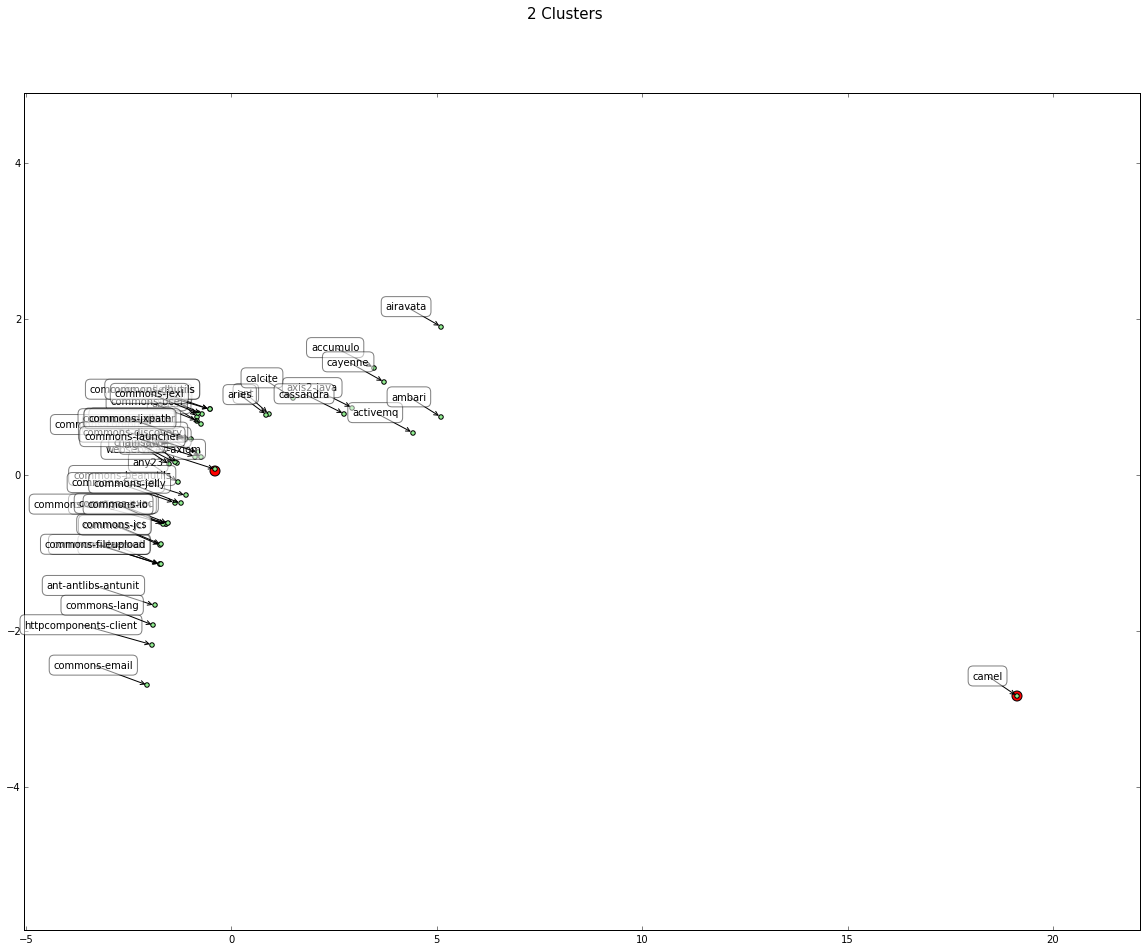

In [37]:
# TWO clusters
NR_CLUSTERS = 2
arr = np.array(rows)
tup = cluster_repos(arr, NR_CLUSTERS)
centroids = tup[0]

plot_cluster(arr, centroids, APACHE_PROJECTS, NR_CLUSTERS, str(NR_CLUSTERS) + ' Clusters')

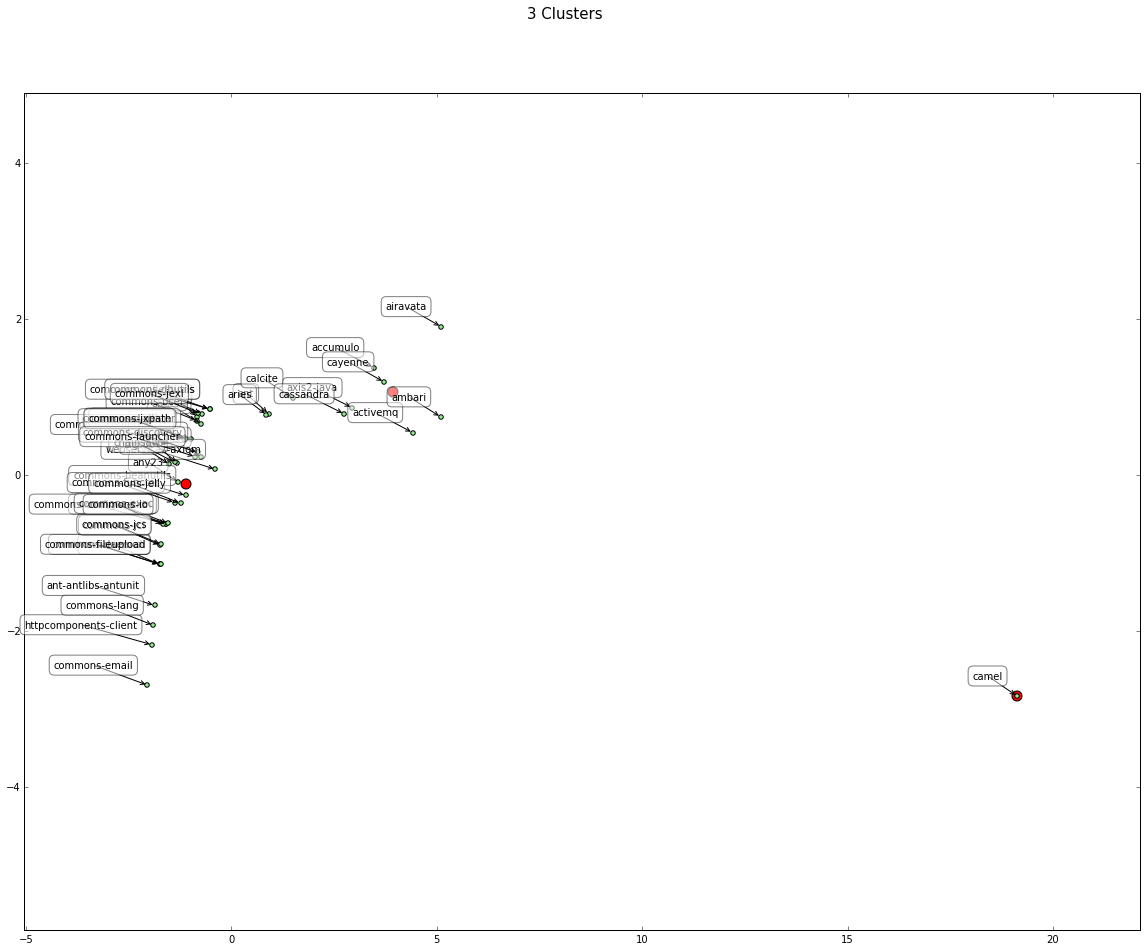

In [38]:
# THREE clusters
NR_CLUSTERS = 3
arr = np.array(rows)
tup = cluster_repos(arr, NR_CLUSTERS)
centroids = tup[0]

plot_cluster(arr, centroids, APACHE_PROJECTS, NR_CLUSTERS, str(NR_CLUSTERS) + ' Clusters')

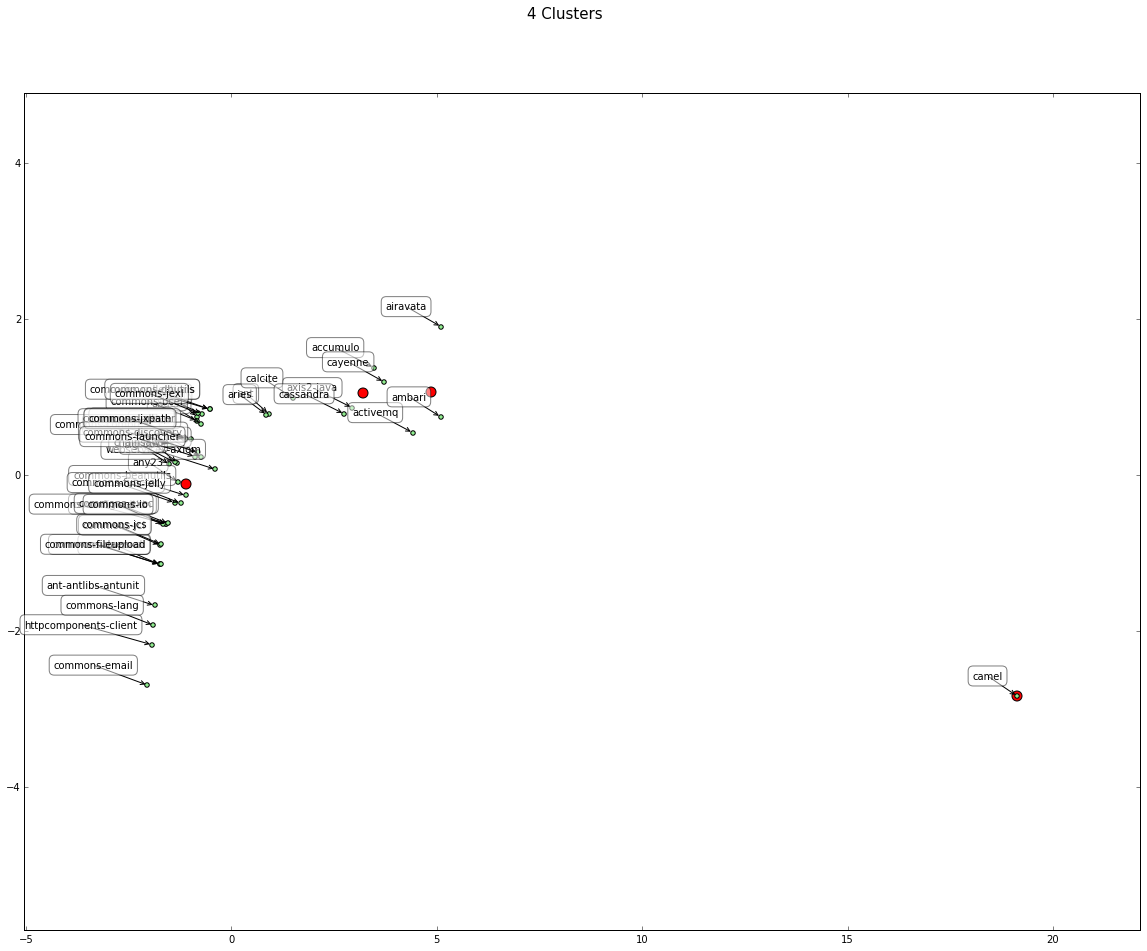

In [39]:
# FOUR clusters
NR_CLUSTERS = 4
arr = np.array(rows)
tup = cluster_repos(arr, NR_CLUSTERS)
centroids = tup[0]

plot_cluster(arr, centroids, APACHE_PROJECTS, NR_CLUSTERS, str(NR_CLUSTERS) + ' Clusters')

### Clustering results

The clustering clearly shows us that three clusters is the optimal amount.
This gives us three clearly defined areas in which all projects can be mapped. The task is now to discover what parameters have the largest importance in this clustering.
We can do this by examining the features of three projects closest to the centroids and comparing them.

### Tabulating mockito, tomcat and elasticsearch

In [21]:
headers = ['Repo', 'Com', 'Ref', 'Inh', 'Line', 'Meth', 'Voc', \
           'Len', 'Vol', 'Diff', 'Eff', 'Time', 'Bug','Cycl']

print tabulate([[names[33]] + [x for x in rows[33]], [names[3]] + [x for x in rows[3]], \
                [names[34]] + [x for x in rows[34]]], headers=headers)

Repo             Com    Ref    Inh    Line    Meth    Voc    Len      Vol    Diff    Eff    Time          Bug          Cycl
-------------  -----  -----  -----  ------  ------  -----  -----  -------  ------  -----  ------  -----------  ------------
mockito         4035    360   8470    9718   70117     34    107   322265   11712   7027   63345    209687093    3774367680
tomcat         22927   1119  69655   32903  529264     36    993  2977592  120705  45376  575945  19967235687  359410242360
elasticsearch  36095   4172  97872   68875  913738     36   1338  4013475  236483  80921  776312  52728811579  949118608425


### Labeling all projects using three clusters

In [7]:
# THREE clusters
NR_CLUSTERS = 3
arr = np.array(rows)
tup = cluster_repos(arr, NR_CLUSTERS)
labels = tup[1]

### Construct a Support Vector Classification model

In [8]:
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(rows, labels)  

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

### Test it

In [9]:
print labels
print clf.predict(rows[3])
print clf.predict(rows[34])

[0 0 1 2 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[2]
[1]


### Analyze JetBrains kotlin project

In [10]:
#repositories = [('qos-ch', 'slf4j'), ('mockito', 'mockito'), ('elastic', 'elasticsearch')]
repositories = [('JetBrains', 'kotlin')]
rows = make_rows(repositories)
print clf.predict(rows[0])

[0]
